Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [277]:
NAME = "Martin Knap"
COLLABORATORS = ""

---

# Domača naloga 5: Geometrijske preslikave in poravnava oblik

1. Izvedite poravnavo vseh 2D oblik `[1, 29]` v datoteki `data/letala.npy` na obliko z indeksom 0 z metodo iterativno najbližje točke. Izrišite v eno sliko vse 2D oblike v začetni legi, v drugo sliko pa vse oblike v poravnani legi. 

 Za vsako poravnavo izračunajte napako pred poravnavo in po njej. V eno sliko narišite histogram vseh napak v začetni legi, v drugo sliko pa histogram napak v poravnani legi. Izpišite vrednost napake in indeks oblike, pri kateri dobite največjo in najmanjšo napako v začetni legi. Obliki tudi izrišite, zraven pa z drugo barvo dorišite še referenčno obliko. Enako naredite tudi za oblike po poravnavi.

1. 1. Prikažite grafa originalnih in poravnanih oblik:

In [278]:
import numpy as np
import matplotlib.pyplot as plt

In [279]:
def mapAffineApprox2D(iPtsRef, iPtsMov):
    """Afina aproksimacijska poravnava"""
    iPtsRef = np.matrix(iPtsRef)
    iPtsMov = np.matrix(iPtsMov)
    
    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)
    
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()
    
    oMat2D = iPtsRef * iPtsMov.transpose() * np.linalg.inv(iPtsMov * iPtsMov.transpose())
    
    return oMat2D

def findCorrespondingPoints(iPtsRef, iPtsMov):
    """Poisci korespondence kot najblizje tocke"""
    iPtsMov = np.array(iPtsMov)
    iPtsRef = np.array(iPtsRef)
    
    idxPair = -np.ones((iPtsRef.shape[0], 1), dtype='int32')
    idxDist = np.ones((iPtsRef.shape[0], iPtsMov.shape[0]))
    for i in range(iPtsRef.shape[0]):
        for j in range(iPtsMov.shape[0]):
            idxDist[i, j] = np.sum((iPtsRef[i, :2] - iPtsMov[j,:2])**2)
            
    while not np.all(idxDist == np.inf):
        i, j = np.where(idxDist == np.min(idxDist))
        idxPair[i[0]] = j[0]
        idxDist[i[0],:] = np.inf
        idxDist[:, j[0]] = np.inf
        
    idxValid, idxNotValid = np.where(idxPair >= 0)
    idxValid = np.array(idxValid)
    iPtsRef_t = iPtsRef[idxValid, :]
    iPtsMov_t = iPtsMov[idxPair[idxValid].flatten(), :]
    return iPtsRef_t, iPtsMov_t

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def transAffine2D(iScale=(1, 1), iTrans=(0, 0), iRot=0, iShear=(0, 0)):
    """Funkcija za poljubno 2D afino preslikavo"""
    iRot = iRot*np.pi/180
    oMatScale = np.array(((iScale[0],0,0),(0,iScale[1],0),(0,0,1)))
    oMatTrans = np.array(((1,0,iTrans[0]),(0,1,iTrans[1]),(0,0,1)))
    oMatRot = np.array(((np.cos(iRot),-np.sin(iRot),0),(np.sin(iRot),np.cos(iRot),0),(0,0,1)))
    oMatShear = np.array(((1,iShear[0],0),(iShear[1],1,0),(0,0,1)))
    oMat2D = np.dot(oMatTrans, np.dot(oMatShear, np.dot(oMatRot, oMatScale)))
    
    return oMat2D


def alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False):
    """Postopek iterativno najblizje tocke"""
    curMat = []; oErr = []; iCurIter = 0
    if plotProgress: 
        iPtsMov0 = np.matrix(iPtsMov)
        fig = plt.figure()
        ax = fig.add_subplot(111)
    while True:
        iPtsRef_t, iPtsMov_t = findCorrespondingPoints(iPtsRef, iPtsMov)
        oMat2D = mapAffineApprox2D(iPtsRef_t, iPtsMov_t)
        iPtsMov = np.dot(addHomCoord2D(iPtsMov), oMat2D.transpose())
        curMat.append(oMat2D)
        oErr.append(np.sqrt(np.sum((iPtsRef_t[:,:2] - iPtsMov_t[:,:2])**2)))
        iCurIter = iCurIter + 1
        dMat = np.abs(oMat2D - transAffine2D())
        if iCurIter > iMaxIter or np.all(dMat < iEps):
            break
            
    oMat2D = transAffine2D()
    for i in range(len(curMat)):
        
        if plotProgress:
            iPtsMov_t = np.dot(addHomCoord2D(iPtsMov0), oMat2D.transpose())
            ax.clear()
            ax.plot(iPtsRef[:,0], iPtsRef[:,1], 'ob')
            ax.plot(iPtsMov_t[:,0], iPtsMov_t[:,1],'om')
            fig.canvas.draw()
            plt.pause(1)
            
        oMat2D = np.dot(curMat[i], oMat2D)
    return oMat2D, oErr

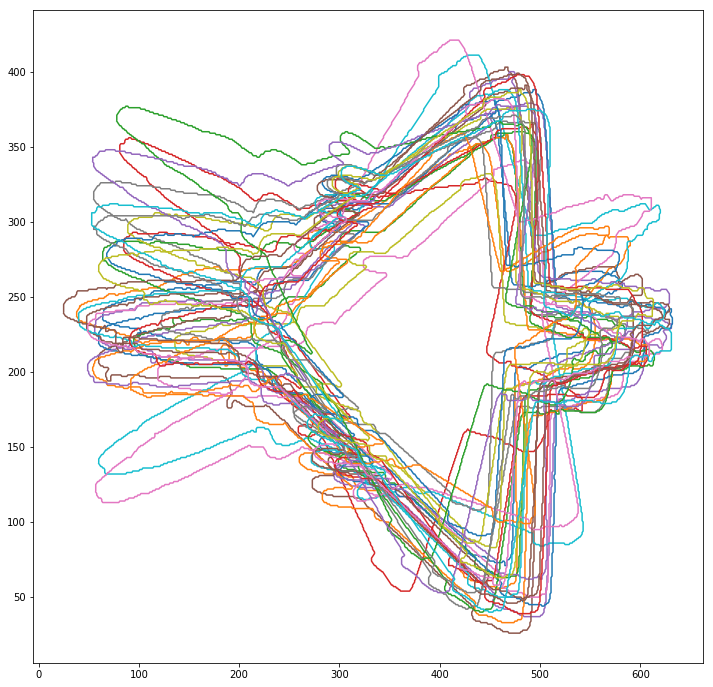

In [280]:
letala = np.load('data/letala.npy')
plt.figure(figsize = (12,12))
for i in range(len(letala)):
    let = letala[i]
    let_x = let[:,0]
    let_y = let[:,1]
    plt.plot(let_x, let_y)

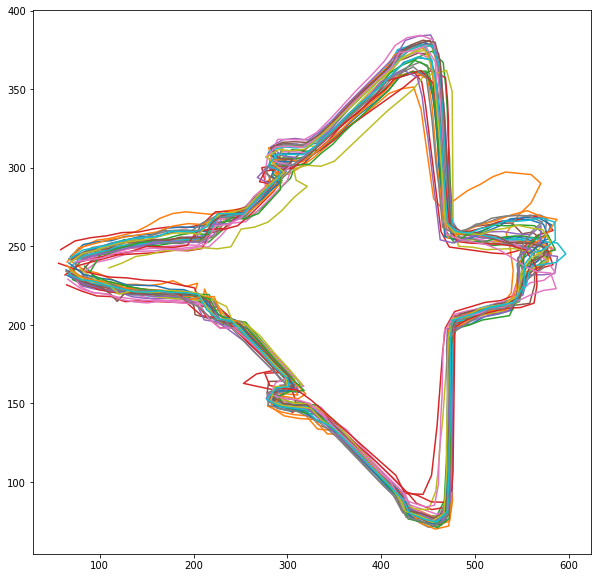

In [281]:
letala = np.load('data/letala.npy')

iPtsRef = letala[0]
iPtsMov = letala[1:len(letala)]

step = 15
iPtsRef = iPtsRef[::step]

plt.figure(figsize = (10,10))
plt.plot(iPtsRef[:,0], iPtsRef[:,1])

# iPtsMov = iPtsMov[0]
# iPtsMov = iPtsMov[::step]

# oMat2D_t, oErr = alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False)
# iPtsMov_t = np.dot(addHomCoord2D(iPtsMov), oMat2D_t.transpose())
# plt.plot(iPtsMov_t[:,0], iPtsMov_t[:,1])
oErrn = []
for i in range(len(iPtsMov)):
    iPtsMovNew = iPtsMov[i]
    iPtsMovDec = iPtsMovNew[::step]
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMovDec, iEps=1e-6, iMaxIter=70, plotProgress=False)
    
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMovDec), oMat2D_t.transpose())
    plt.plot(iPtsMov_t[:,0], iPtsMov_t[:,1])
    


1. 2. Za vsako poravnano sliko izračunajte napako pred poravnavo in po njej. Narišite histogram vseh napak v začetni legi in histogram napak v poravnani legi.

In [282]:
letala = np.load('data/letala.npy')

iPtsRef = letala[0]
iPtsMov = letala[1:len(letala)]

step = 25
iPtsRef = iPtsRef[::step]

# plt.figure(figsize = (10,10))
# plt.plot(iPtsRef[:,0], iPtsRef[:,1])

oErrFirst = []
oErrLast = []

for i in range(len(iPtsMov)):
    iPtsMovNew = iPtsMov[i]
    iPtsMovDec = iPtsMovNew[::step]
    
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMovDec, iEps=1e-6, iMaxIter=70, plotProgress=False)
    
    oErrFirst.append(oErr[0])
    oErrLast.append(oErr[-1])
    

<BarContainer object of 29 artists>

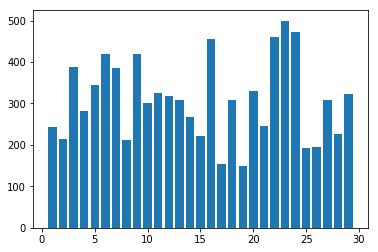

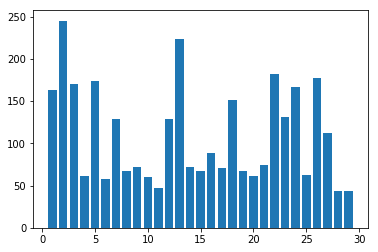

In [283]:
st_let = np.linspace(1,len(iPtsMov),len(iPtsMov))
plt.figure()
plt.bar(st_let, oErrFirst)
plt.figure()
plt.bar(st_let, oErrLast)

1. 3. Izpišite vrednost napake in indeks oblike, pri kateri dobite največjo in najmanjšo napako v začetni legi. Obliki tudi izrišite, zraven pa z drugo barvo dorišite še referenčno obliko. Enako naredite tudi za oblike po poravnavi.

Najmanjša napaka znaša 147.9155164274526 pri obliki št. 18
Največja napaka znaša 499.48873861179294 pri obliki št. 22


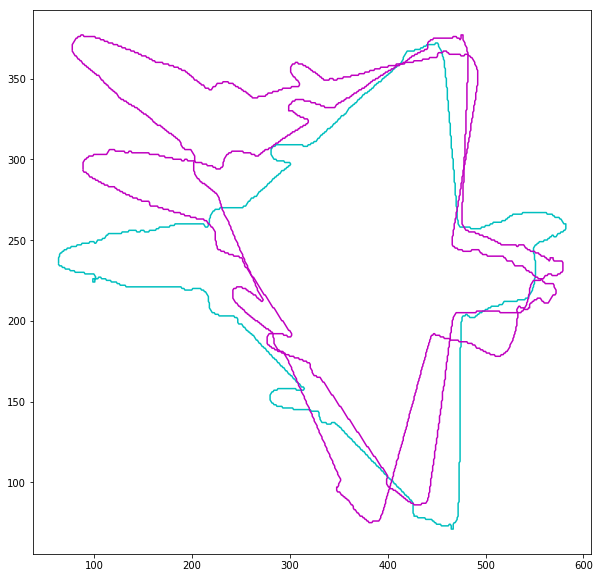

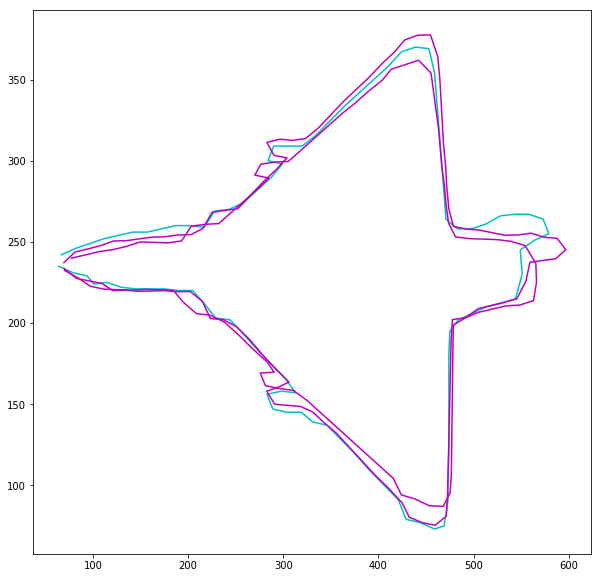

In [284]:
FirstErrMin = np.min(oErrFirst)
FirstErrMax = np.max(oErrFirst)
PozMin = np.where(oErrFirst == FirstErrMin)
PozMax = np.where(oErrFirst == FirstErrMax)

print("Najmanjša napaka znaša", FirstErrMin,"pri obliki št.", int(PozMin[0]))
print("Največja napaka znaša", FirstErrMax,"pri obliki št.", int(PozMax[0]))

letala = np.load('data/letala.npy')

iPtsRef = letala[0]
iPtsPreMov = [letala[int(PozMin[0])], letala[int(PozMax[0])]]
plt.figure(figsize = (10,10))
plt.plot(iPtsRef[:,0],iPtsRef[:,1],'c')

for i in range(len(iPtsPreMov)):
    pts = iPtsPreMov[i]
    plt.plot(pts[:,0], pts[:,1],'m')


#izris po poravnavi


iPtsRef = letala[0]
iPtsMov = letala[1:len(letala)]

step = 15
iPtsRef = iPtsRef[::step]

plt.figure(figsize = (10,10))
plt.plot(iPtsRef[:,0], iPtsRef[:,1],'c')

idx = [int(PozMin[0]), int(PozMax[0])]
for i in range(len(idx)):
    j = idx[i]
    iPtsMovNew = iPtsMov[j]
    iPtsMovDec = iPtsMovNew[::step]
    
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMovDec, iEps=1e-6, iMaxIter=70, plotProgress=False)
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMovDec), oMat2D_t.transpose())
    plt.plot(iPtsMov_t[:,0], iPtsMov_t[:,1],'m')

2. Naložite poljubno obliko iz dane zbirke in načrtajte ustrezno zaporedje 2D linearnih preslikav tako, da se bo oblika rotirala okoli svojega središča. Prikažite delovanje preslikave tako, da obliko rotirate od $0 - 360^{\circ}$ s korakom $5^{\circ}$ ter hkrati prikazujete točke oblike v istem prikaznem oknu. Za vsak korak z metodo iterativno najbližje točke poravnajte rotirano obliko v nerotirano obliko (kot $0^{\circ}$). Ali je poravnava uspešna za vse rotacije? Pokažite tako, da za vsak korak izračunate napako kot povprečno razdaljo med istoindeksiranimi točkami v referenčni in poravnani obliki. Napako prikažite na grafu v odvisnosti od kota rotacije.

2. 1. Rotirajte obliko okrog svojeg središča od 0 do 360 stopinj in prikazujte točke oblike v istem prikaznem oknu:

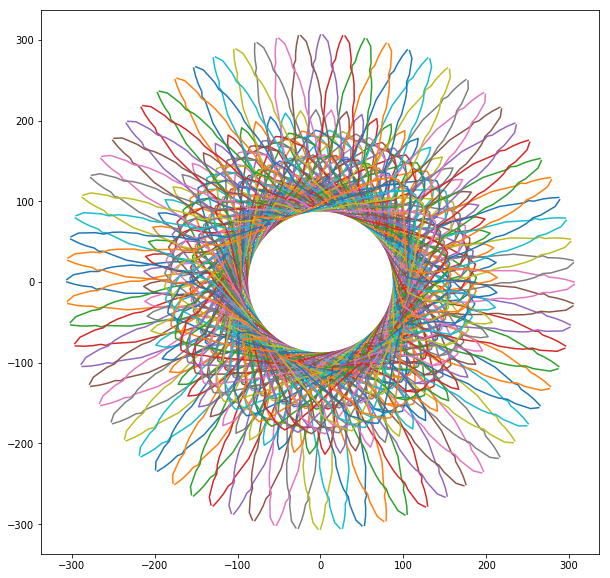

In [285]:
# Nalozimo tocke
step = 10
let0 = np.load('data/letala.npy')[0]
let0 = let0[::step,]

#poravnava v sredisce
slika_t2D = transAffine2D([1,1], [-370,-235], 0, [0,0])
let0 = np.dot(addHomCoord2D(let0), slika_t2D.transpose())

# plt.figure(figsize = (10, 10))
# plt.plot(let0[:,0], let0[:,1])
# Inicializiramo graf
# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.figure(figsize = (10,10))

for alpha in range(0, 360, 5):
    # Implementiramo rotacijo
    slika_t2D = transAffine2D([1,1], [0,0], alpha, [0,0])
    let_rot = np.dot(addHomCoord2D(let0), slika_t2D.transpose())
    plt.plot(let_rot[:,0], let_rot[:,1])

#     # Narisemo graf rotirane oblike
#     ax.clear()
#     ax.set_xlim(0, 650)
#     ax.set_ylim(-100, 550)
#     ax.plot(let_rot[:,0], let_rot[:,1], 'ob')
#     fig.canvas.draw()

2. 2. Za vsak korak z metodo iterativno najbližje točke poravnajte rotirano obliko v nerotirano obliko (kot $0^{\circ}$).

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355


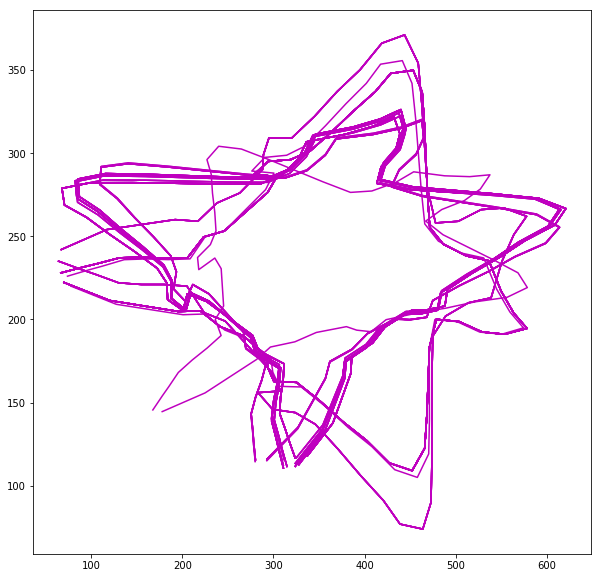

In [286]:
step = 25
let0 = np.load('data/letala.npy')[0]
let0 = let0[::step]
iPtsRef = let0
plt.figure(figsize = (10,10))
# plt.plot(iPtsRef[:,0], iPtsRef[:,1],'c')
for alpha in range(0, 360, 5):
    # Implementiramo rotacijo
    slika_t2D = transAffine2D([1,1], [0,0], alpha, [0,0])
    let_rot = np.dot(addHomCoord2D(let0), slika_t2D.transpose())
    iPtsMov = let_rot[:,0:2]
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=100, plotProgress=False)
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMov), oMat2D_t.transpose())
    plt.plot(iPtsMov_t[:,0], iPtsMov_t[:,1],'m')
    print(alpha)

2. 3. Ali je poravnava uspešna za vse rotacije? Pokažite tako, da za vsak korak izračunate napako kot povprečno razdaljo med istoindeksiranimi točkami v referenčni in poravnani obliki. Napako prikažite na grafu v odvisnosti od kota rotacije.

In [287]:
step = 25
let0 = np.load('data/letala.npy')[0]
let0 = let0[::step]
iPtsRef = let0

avg_errs = []

for alpha in range(0, 360, 5):
    # Implementiramo rotacijo
    slika_t2D = transAffine2D([1,1], [0,0], alpha, [0,0])
    let_rot = np.dot(addHomCoord2D(let0), slika_t2D.transpose())
    iPtsMov = let_rot[:,0:2]
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=100, plotProgress=False)
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMov), oMat2D_t.transpose())
    
    avg_err2D = np.zeros_like(iPtsMov_t[:,0])
    for i in range(len(iPtsMov_t)):
        x_err = iPtsRef[i, 0] - iPtsMov_t[i, 0]
        y_err = iPtsRef[i, 1] - iPtsMov_t[i, 1]
        avg_err2D[i] = np.sqrt(x_err**2 + y_err**2)
    avg_err = np.sum(avg_err2D)/len(iPtsMov_t)
    
    avg_errs.append(avg_err)

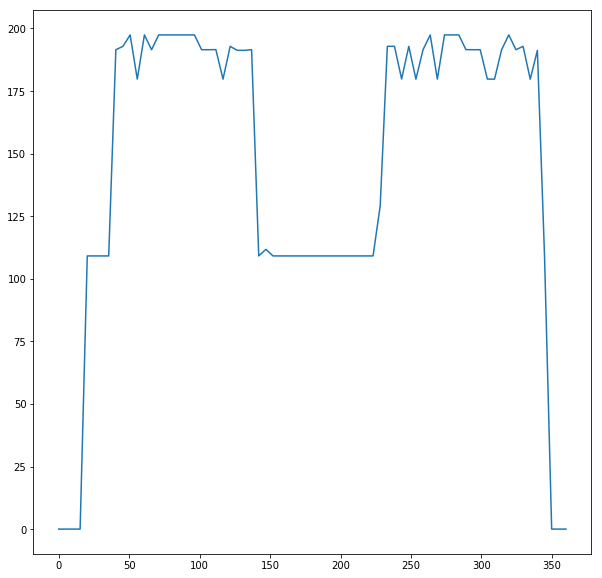

In [288]:
kot = np.linspace(0,360,72)
plt.figure(figsize = (10,10))
plt.plot(kot, avg_errs)

3. Napišite funkcijo, ki ustvari $4 \times 4$ matriko poljubne 3D afine preslikave:
```python
    def transAffine3D( iScale, iTrans, iRot, iShear ):
	  	return oMat3D
```
 kjer je `iScale` trivrstični vektor s parametri skale $k_x,\,k_y$ in $k_z$, `iTrans` trivrstični vektor s parametri translacije $t_x,\,t_y$ in $t_z$, `iRot` trivrstični vektor s koti rotacije $\alpha,\,\beta$ in $\gamma$ v stopinjah in `iShear` šestvrstični vektor s parametri striga $g_{xy},\,g_{xz},\,g_{yx},\,g_{zx},\,g_{zy},\,g_{yz}$. Funkcija vrne homogeno matriko `oMat3D`, ki ima dimenzije $4 \times 4$. Preverite delovanje funkcije na 3D oblikah v datoteki `data/glave.npy` tako, da točke izbrane oblike preslikate s poljubnimi parametri striga, rotacije, translacije in skaliranja, nato pa še s poljubno 3D afino preslikavo. Vhodne in preslikane točke oblike prikažite z dano funkcijo `renderSurface.py`.

 Izbrano obliko rotirajte za $180^{\circ}$ okrog svojega središča in okrog poljubne osi. Prikažite glavo pred in po poravnavi.
 
 Namig: Vseh pet 3D oblik naložite z ukazom `glave = numpy.load('data/glave.npy')`. 3D oblike so zapisane v seznamu tipa `list`, točke prve oblike dobite z ukazom `x = glave[0]` 

3. 1. Implementirajte funkcijo `transAffine3D`:

In [289]:
def transAffine3D(iScale=(1, 1, 1), iTrans=(0, 0, 0), iRot= (0, 0, 0), iShear=(0, 0, 0, 0, 0, 0)):
    """Funkcija za poljubno 3D afino preslikavo"""
    #iRot = iRot*np.pi/180
    iRot = np.radians(iRot)
    oMatScale = np.array(((iScale[0],0,0,0),(0,iScale[1],0,0),(0,0,iScale[2],0),(0,0,0,1)))
    oMatTrans = np.array(((1,0,0,iTrans[0]),(0,1,0,iTrans[1]),(0,0,1,iTrans[2]),(0,0,0,1)))
    #oMatRot = np.array(((np.cos(iRot),-np.sin(iRot),0),(np.sin(iRot),np.cos(iRot),0),(0,0,1)))
    MatRotAlpha = np.array(((np.cos(iRot[0]),-np.sin(iRot[0]),0,0),(np.sin(iRot[0]),np.cos(iRot[0]),0,0),(0,0,1,0),(0,0,0,1)))
    MatRotBeta = np.array(((np.cos(iRot[1]),0,np.sin(iRot[1]),0),(0,1,0,0),(-np.sin(iRot[1]),0,np.cos(iRot[1]),0),(0,0,0,1)))
    MatRotGamma = np.array(((1,0,0,0),(0,np.cos(iRot[2]),-np.sin(iRot[2]),0),(0,np.sin(iRot[2]),np.cos(iRot[2]),0),(0,0,0,1)))
    oMatRot = np.dot(MatRotGamma,np.dot(MatRotAlpha,MatRotBeta))
    oMatShear = np.array(((1,iShear[0],iShear[1],0),(iShear[2],1,iShear[3],0),(iShear[4],iShear[5],1,0),(0,0,0,1)))
    oMat3D = np.dot(oMatTrans, np.dot(oMatShear, np.dot(oMatRot, oMatScale)))
    
    return oMat3D

def addHomCoord3D(iPts):
    if iPts.shape[-1] == 4:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

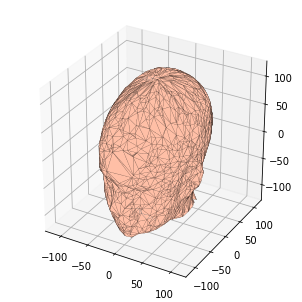

In [290]:
# Primer uporabe funkcije renderSurface
import numpy as np
from renderSurface import renderSurface
#%matplotlib notebook

glave = np.load('data/glave.npy')
x = glave[0]
x.shape
renderSurface(x[:,0], x[:,1], x[:,2])

3. 2. Preverite delovanje funkcije na 3D oblikah v datoteki `data/glave.npy` tako, da točke izbrane oblike preslikate s poljubnimi parametri striga, rotacije, translacije in skaliranja, nato pa še s poljubno 3D afino preslikavo. Vhodne in preslikane točke oblike prikažite z dano funkcijo `renderSurface.py`.

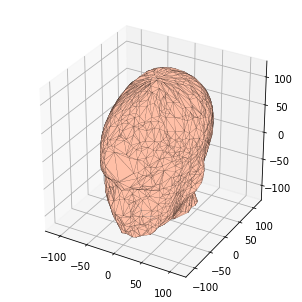

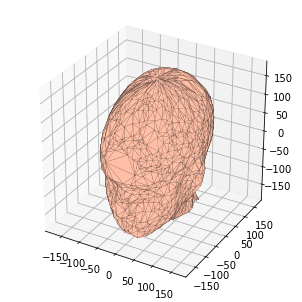

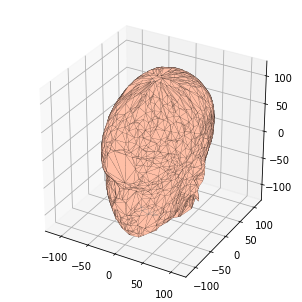

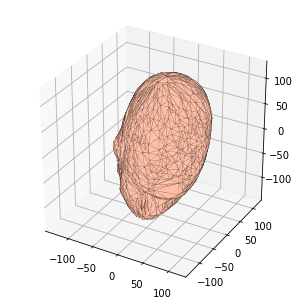

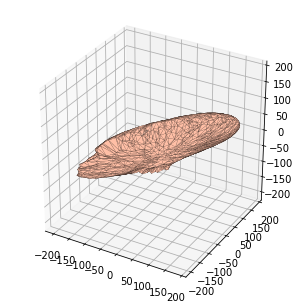

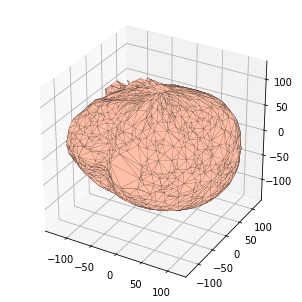

In [291]:
# Primer uporabe funkcije renderSurface
import numpy as np
from renderSurface import renderSurface
#%matplotlib notebook

# for i in range(len(glave)):
#     gl = glave[i]
#     gl.shape
#     renderSurface(gl[:,0],gl[:,1],gl[:,2])

glave = np.load('data/glave.npy')


x = glave[0]
x.shape
renderSurface(x[:,0], x[:,1], x[:,2])

#skaliranje
oMat3D1 = transAffine3D(iScale=(1.5, 1.5, 1.5), iTrans=(0, 0, 0), iRot= (0, 0, 0), iShear=(0, 0, 0, 0, 0, 0))
x1_t =  np.dot(addHomCoord3D(x), oMat3D1.transpose())
x1_t.shape
renderSurface(x1_t[:,0], x1_t[:,1], x1_t[:,2])

#translacija

oMat3D2 = transAffine3D((1, 1, 1), (1000, 0, 0), (0, 0, 0), (0, 0, 0, 0, 0, 0))
x2_t =  np.dot(addHomCoord3D(x), oMat3D2.transpose())
x2_t.shape
renderSurface(x2_t[:,0], x2_t[:,1], x2_t[:,2])

#rotacija

oMat3D3 = transAffine3D((1, 1, 1), (0, 0, 0), (30, 30, 30), (0, 0, 0, 0, 0, 0))
x3_t =  np.dot(addHomCoord3D(x), oMat3D3.transpose())
x3_t.shape
renderSurface(x3_t[:,0], x3_t[:,1], x3_t[:,2])

#strig

oMat3D4 = transAffine3D((1, 1, 1), (0, 0, 0), (0, 0, 0), (1, 1, 0, 0, 0, 0))
x4_t =  np.dot(addHomCoord3D(x), oMat3D4.transpose())
x4_t.shape
renderSurface(x4_t[:,0], x4_t[:,1], x4_t[:,2])

#poljubna

oMat3D5 = transAffine3D((1.5, 1, 1), (100, 0, 0), (0, 90, 0), (0.2, 0, 0, 0, 0, 0))
x5_t =  np.dot(addHomCoord3D(x), oMat3D5.transpose())
x5_t.shape
renderSurface(x5_t[:,0], x5_t[:,1], x5_t[:,2])

3. 3. Izbrano obliko rotirajte za $180^{\circ}$ okrog svojega središča in okrog poljubne osi. Prikažite glavo pred in po poravnavi.

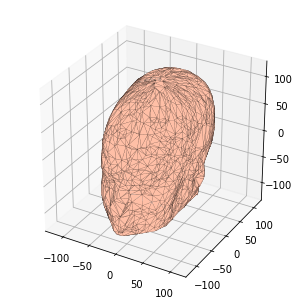

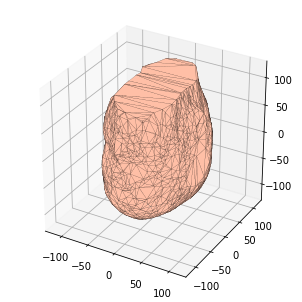

In [292]:
x = glave[4]
x.shape
renderSurface(x[:,0], x[:,1], x[:,2])

oMat3D = transAffine3D(iScale=(1, 1, 1), iTrans=(0, 0, 0), iRot= (0, 180, 0), iShear=(0, 0, 0, 0, 0, 0))
x_t =  np.dot(addHomCoord3D(x), oMat3D.transpose())
x_t.shape
renderSurface(x_t[:,0], x_t[:,1], x_t[:,2])

4. 1. Napišite funkcijo za poravnavo dveh 3D oblik z metodo iterativno najbližje točke (ICP):
```python
    def alignICP3D( iPtsRef, iPtsMov, iEps, iMaxIter ):
        return oMat3D, oErr
```
kjer sta `iPtsRef` in `iPtsMov` matriki s koordinatami referenčnih in premičnih točk. Matriki imata dimenziji $K_R \times 3$ in $K_M \times 3$. `iEps` in `iMaxIter` določata pogoje za zaustavitev postopka, kjer je `iEps` najmanjša sprememba parametrov preslikave, `iMaxIter` pa maksimalno število korakov $k_{max}$. V funkciji uporabite 3D afino aproksimacijsko poravnavo, funkcija pa naj vrne optimalno 3D afino preslikavo med referenčnimi in premičnimi točkami v obliki homogene matrike `oMat3D` in vektor `oErr`, ki podaja napako $\Sigma^2$ med korespondenčnimi točkami v vsakem koraku metode ICP. 

In [293]:
def mapAffineApprox3D(iPtsRef, iPtsMov):
    """Afina aproksimacijska poravnava"""
    iPtsRef = np.matrix(iPtsRef)
    iPtsMov = np.matrix(iPtsMov)
    
    iPtsRef = addHomCoord3D(iPtsRef)
    iPtsMov = addHomCoord3D(iPtsMov)
    
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()
    
    oMat3D = iPtsRef * iPtsMov.transpose() * np.linalg.inv(iPtsMov * iPtsMov.transpose())
    
    return oMat3D

def findCorrespondingPoints3D(iPtsRef, iPtsMov):
    """Poisci korespondence kot najblizje tocke"""
    iPtsMov = np.array(iPtsMov)
    iPtsRef = np.array(iPtsRef)
    
    idxPair = -np.ones((iPtsRef.shape[0], 1), dtype='int32')
    idxDist = np.ones((iPtsRef.shape[0], iPtsMov.shape[0]))
    for i in range(iPtsRef.shape[0]):
        for j in range(iPtsMov.shape[0]):
                idxDist[i, j] = np.sum((iPtsRef[i, :3] - iPtsMov[j,:3])**2)
            
    while not np.all(idxDist == np.inf):
        i, j = np.where(idxDist == np.min(idxDist))
        idxPair[i[0]] = j[0]
        idxDist[i[0],:] = np.inf
        idxDist[:, j[0]] = np.inf
        
    idxValid, idxNotValid = np.where(idxPair >= 0)
    idxValid = np.array(idxValid)
    iPtsRef_t = iPtsRef[idxValid, :]
    iPtsMov_t = iPtsMov[idxPair[idxValid].flatten(), :]
    return iPtsRef_t, iPtsMov_t

In [294]:
def alignICP3D(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50):
    """Postopek iterativno najblizje tocke"""
    curMat = []; oErr = []; iCurIter = 0
    while True:
        iPtsRef_t, iPtsMov_t = findCorrespondingPoints3D(iPtsRef, iPtsMov)
        oMat3D = mapAffineApprox3D(iPtsRef_t, iPtsMov_t)
        iPtsMov = np.dot(addHomCoord3D(iPtsMov), oMat3D.transpose())
        curMat.append(oMat3D)
        #oErr.append(np.sqrt(np.sum(iPtsRef_t[:,:3] - iPtsMov_t[:,:3])**2)))
        oErr.append(np.sqrt(np.sum((iPtsRef_t[:,:3] - iPtsMov_t[:,:3])**2)))
        iCurIter = iCurIter + 1
        dMat = np.abs(oMat3D - transAffine3D())
        if iCurIter > iMaxIter or np.all(dMat <iEps):
            break
    
    oMat3D = transAffine3D()
    for i in range(len(curMat)):
        oMat3D = np.dot(curMat[i], oMat3D)
    return oMat3D, oErr

4. 2. Preverite pravilnost delovanja funkcije tako, da vse točke izbrane oblike preslikate s poljubnimi parametri 3D afine preslikave in preverite ali funkcija vrne preslikavo v `oMat3D`, ki je podobna dani vaši 3D afini preslikavi in da je končna napaka `oErr` manjša od začetne napake in približno enaka 0. Naložite referenčne in premične točke dveh poljubnih, a različnih oblik iz dane zbirke glav in preverite, da funkcija obliki ustrezno poravna.

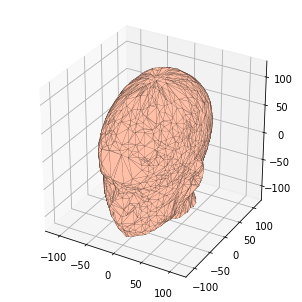

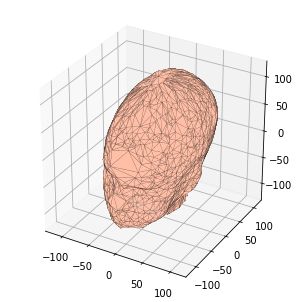

In [295]:
from renderSurface import renderSurface
glave = np.load('data/glave.npy')
x_orig = glave[0]
x_orig.shape
renderSurface(x_orig[:,0],x_orig[:,1],x_orig[:,2])

oMat3D = transAffine3D(iScale=(1, 1, 1), iTrans=(20, 0, 0), iRot= (0, 10, 0), iShear=(0, 0, 0, 0, 0, 0))
x_t =  np.dot(addHomCoord3D(x_orig), oMat3D.transpose())
x_t.shape
renderSurface(x_t[:,0], x_t[:,1], x_t[:,2])

2.801523070806706e-12


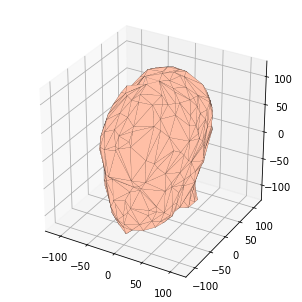

In [296]:
x_t = x_t[:,:3]
step = 400
x_orig = x_orig[::step,:]
x_t = x_t[::step,:]
# print(x_orig.shape)
# print(x_t.shape)
oMat3D_t, oErr = alignICP3D(x_orig, x_t, iEps=1e-6, iMaxIter=100)
x_t2 = np.dot(addHomCoord3D(x_t), oMat3D_t.transpose())
x_t2 = x_t2[:,:3]
print(oErr[-1])

#izris glave v poravnanem položaju
renderSurface(np.squeeze(np.asarray(x_t2[:,0])), np.squeeze(np.asarray(x_t2[:,1])), np.squeeze(np.asarray(x_t2[:,2])))

4. 3. Izvedite poravnavo vseh 3D oblik `[1, 4]` na obliko z indeksom 0. Izpišite najmanjšo in največjo vrednost napake `oErr` pred poravnavno in po njej.

In [297]:
glave = np.load('data/glave.npy')
x1 = glave[0]
x2 = glave[1]
x3 = glave[2]
x4 = glave[3]
x5 = glave[4]
step = 400
x1 = x1[::step,:]
x2 = x2[::step,:]
x3 = x3[::step,:]
x4 = x4[::step,:]
x5 = x5[::step,:]

#1. poravnava
oMat3D_t1, oErr1 = alignICP3D(x1, x2, iEps=1e-6, iMaxIter=100)
x2_t = np.dot(addHomCoord3D(x2), oMat3D_t1.transpose())

#2. poravnava
oMat3D_t2, oErr2 = alignICP3D(x1, x3, iEps=1e-6, iMaxIter=100)
x3_t = np.dot(addHomCoord3D(x3), oMat3D_t2.transpose())

#3. poravnava
oMat3D_t3, oErr3 = alignICP3D(x1, x4, iEps=1e-6, iMaxIter=100)
x4_t = np.dot(addHomCoord3D(x4), oMat3D_t3.transpose())

#4. poravnava
oMat3D_t4, oErr4 = alignICP3D(x1, x5, iEps=1e-6, iMaxIter=100)
x5_t = np.dot(addHomCoord3D(x5), oMat3D_t4.transpose())

In [300]:
print("1. poravnava:")
print("napaka pred poravnavo:", oErr1[0])
print("napaka po poravnavi:", oErr1[-1])
print("min. napaka:", np.min(oErr1))
print("max. napaka:", np.max(oErr1))

print("2. poravnava:")
print("napaka pred poravnavo:", oErr2[0])
print("napaka po poravnavi:", oErr2[-1])
print("min. napaka:", np.min(oErr2))
print("max. napaka:", np.max(oErr2))

print("3. poravnava:")
print("napaka pred poravnavo:", oErr3[0])
print("napaka po poravnavi:", oErr3[-1])
print("min. napaka:", np.min(oErr3))
print("max. napaka:", np.max(oErr3))

print("4. poravnava:")
print("napaka pred poravnavo:", oErr4[0])
print("napaka po poravnavi:", oErr4[-1])
print("min. napaka:", np.min(oErr4))
print("max. napaka:", np.max(oErr4))

print("------------------------------------")

#napaka pred/po poravnavi
oErrFirst = np.hstack([oErr1[0], oErr2[0], oErr3[0], oErr4[0]])
oErrLast = np.hstack([oErr1[-1], oErr2[-1], oErr3[-1], oErr4[-1]])
print("najmanjša napaka pred poravnavo:", np.min(oErrFirst))
print("največja napaka pred poravnavo:", np.max(oErrFirst))
print("najmanjša napaka po poravnavi:", np.min(oErrLast))
print("največja napaka po poravnavi:", np.max(oErrLast))



1. poravnava:
napaka pred poravnavo: 85.61541917201598
napaka po poravnavi: 486.8168640749332
min. napaka: 85.61541917201598
max. napaka: 1577.4170334029204
2. poravnava:
napaka pred poravnavo: 1163.847498601084
napaka po poravnavi: 420.48543936785063
min. napaka: 413.67680759525666
max. napaka: 1163.847498601084
3. poravnava:
napaka pred poravnavo: 636.5618587380177
napaka po poravnavi: 313.72491090328793
min. napaka: 313.6807554271914
max. napaka: 636.5618587380177
4. poravnava:
napaka pred poravnavo: 94.94735383358507
napaka po poravnavi: 525.6727589437717
min. napaka: 94.94735383358507
max. napaka: 1743.8587858586202
------------------------------------
najmanjša napaka pred poravnavo: 85.61541917201598
največja napaka pred poravnavo: 1163.847498601084
najmanjša napaka po poravnavi: 313.72491090328793
največja napaka po poravnavi: 525.6727589437717
